# Variational Autoencoder Galaxy generator

## Import libraries

In [1]:
import os
from glob import glob
from utils.custom_utils import RetrieveData, show_images
import random as rd

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## Download data

In [2]:
DataURL='https://tinyurl.com/mr2yc5nx'

RetrieveData(DataURL)

## dataloader and data verification

In [3]:
image_path='./data/images_gz2/images'

In [33]:
class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=None):
        self.transform = transform
        self.img_dir = img_dir
        
        images = glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        
        cut = int(0.6*len(images))
        if train==True:
            self.images = images[:cut]
        elif train==False:
            self.images = images[cut:]
        else:
            self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_to_tensor = transforms.Compose([transforms.PILToTensor()])
        img_path = self.images[index]
        with Image.open(img_path) as im:
            im = img_to_tensor(im)
            if self.transform:
                im = self.transform(im)
            return im.float()

In [34]:
trainset=GalaxyZoo2(image_path)

In [35]:
trainloader=DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

torch.Size([4, 3, 424, 424])


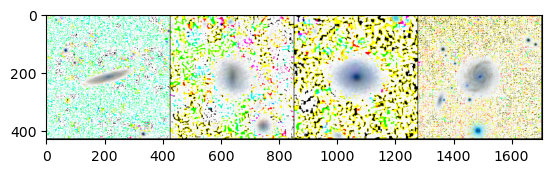

In [36]:
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

## VAE

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 424
channels = 3
batch_size = 32

#hyperparameters of the NN specifically
input_features = channels*image_size*image_size # RGB pixel (dim=3)* 424*424 image
output_features = 128 # size of output of encoder = input of decoder
hidden_features = 200 # arbitrary
latent_space_size = 20 #size of the latent space --> arbitrary
learning_rate = 3e-4 # arbitrary
num_epochs = 10 # arbitrary

model_name = "MLP_VAE"
#directory = ""
#checkpoint = f"{directory}/{model_name}.pt"

this instance use cuda


In [ ]:
# WandB
wandb.init(
    project="vae",
    config={
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
    }
)

wandb: Currently logged in as: clement-laisney. Use `wandb login --relogin` to force relogin


In [45]:
class MLP_VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Linear(input_features, hidden_features),
                                     nn.ReLU(),
                                     nn.Linear(hidden_features, output_features),
                                    )
        
        self.mu = nn.Linear(output_features, latent_dim)
        self.logvar= nn.Linear(output_features, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, output_features)
        
        self.decoder = nn.Sequential(nn.Linear(output_features, hidden_features),
                                     nn.ReLU(),
                                     nn.Linear(hidden_features, input_features),
                                    )
        
    def encode(self, x):
        x = x.view(x.size(0),-1)
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
            
        return mu, logvar
        
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
            
        return mu + eps * torch.exp(0.5 * logvar)
        
    def decode(self, z, x):
        latent_z = self.sample_z(z)
        out = self.decoder(latent_z)
        reshaped_out = torch.sigmoid(out).view(x.shape[0], channels, image_size, image_size)
            
        return reshaped_out
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output= self.decode(z, x)
            
        return output, mu, logvar

torch.Size([32, 3, 424, 424])


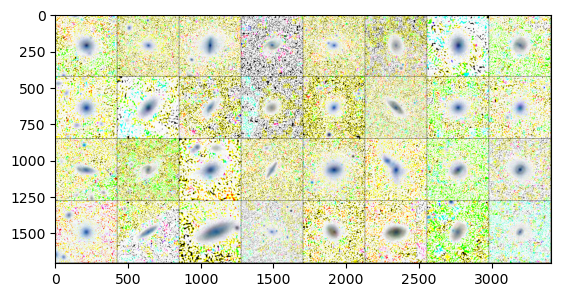

In [ ]:
trainset=GalaxyZoo2(image_path)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

model = MLP_VAE(latent_space_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.BCELoss(reduction='sum')

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(trainloader))
    for i,x in loop:
        x= x.to(device)
        output, mu, logvar = model(x)
        
        reconstruction_loss = loss(output, x)
        kl_div = 0.5*torch.sum(1+ logvar - mu**2 - torch.exp(logvar))
        
        loss = reconstruction_loss - kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

0it [00:00, ?it/s]


TypeError: MLP_VAE.sample_z() missing 1 required positional argument: 'logvar'